In [130]:
#default_exp charge

# PV Forecasting

<br>

## Battery charging: problem definition

The goal of the battery charging component is to maximise the amount of charge that is drawn from solar PV, as opposed to the grid. We want to maximise: 

$$p_{d,1} = \frac{\sum{P_{d,k}}}{\sum{B_{d,k}}}$$

summing over all $k$ periods during which we can charge. We are allowed to charge during $k=1,...31$ or between 00:00 and 15:30 (that is the settlement period ending at 15:30).

##### Constraints

As with the battery discharge, the battery has a number of constraints. The first constraint is on the maximum import and export of energy, in this case:

$$-2.5MW = B_{min} \leq B_{d, k} \leq B_{max} = 2.5MW$$

Secondly the battery cannot charge beyond its capacity, $C_{d, k}$, (in MWh):

$$0 \leq C_{d, k} \leq C_{max} = 6MWh$$

The total charge in the battery at the next time step $C_{d, k+1}$ is related to how much is currently in the battery and how much charged within the battery at time $k$, i.e.

$$C_{d, k+1} = C_{d, k} + 0.5B_{d, k}$$

Finally, the battery must start empty at the start of each day in the test week. I.e. $C_{d,1} = 0$ for $d = 1, … , 7$.

##### Output

The output should be roughly the same as the battery discharge, except with positive values to indicate charging. E.g.

```
charging_profile = [
0, ## 00:00--00:30
0, ## 00:30--01:00
...
1.2, ## 14:30--15:00
0.7] ## 15:00--15:30

```

### Imports

In [131]:
#exports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from moepy.lowess import quantile_model
from sklearn.linear_model import LinearRegression

from batopt import clean
from batopt.discharge import sample_random_day

import FEAutils as hlp

In [132]:
# Should do some investigation of how the panel temp influences performance

In [133]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'

In [134]:
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)

df.head()

,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
datetime,,,,,,,,,,,,,,,,
2017-11-03 00:00:00+00:00,2.19,0.0,7.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.560,9.640,7.46,6.680,13.090,13.20
2017-11-03 00:30:00+00:00,2.14,0.0,7.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.625,9.675,7.30,6.475,13.150,13.26
2017-11-03 01:00:00+00:00,2.01,0.0,7.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.690,9.710,7.14,6.270,13.210,13.32
2017-11-03 01:30:00+00:00,1.87,0.0,7.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.715,9.720,7.00,6.090,13.255,13.34
2017-11-03 02:00:00+00:00,1.86,0.0,7.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.740,9.730,6.86,5.910,13.300,13.36


Correlations between the solar variables:

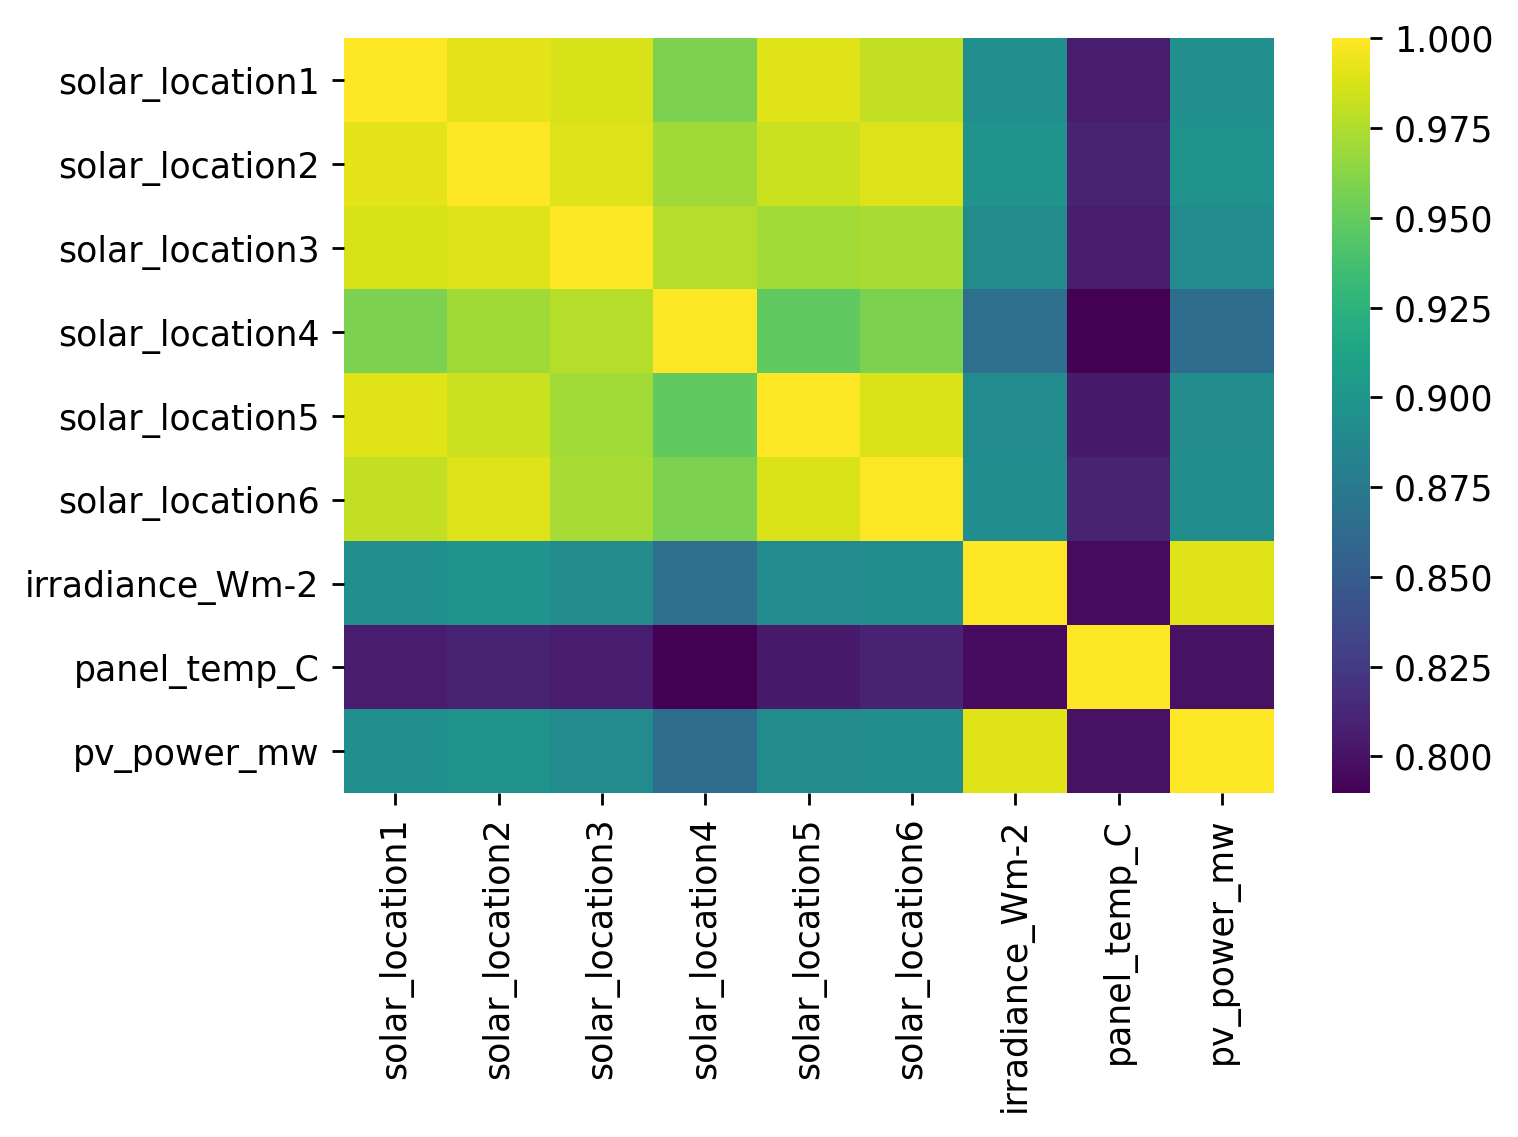

In [135]:
solar_cols = [c for c in df.columns if 'solar_location' in c]
solar_cols.append('irradiance_Wm-2')
solar_cols.append('panel_temp_C')
solar_cols.append('pv_power_mw')

fig, ax = plt.subplots(dpi=250)
df_solar = df.filter(solar_cols).copy()
ax = sns.heatmap(df_solar.corr(), cmap='viridis')
fig.savefig('../img/solar_corrplot.png')

As in the demand data, estimating the quantiles for the solar PV output:

In [136]:
#exports
def estimate_daily_solar_quantiles(x, y, x_pred = np.linspace(0, 23.5, 100), **model_kwargs):
    # Fitting the model
    df_quantiles = quantile_model(x, y, x_pred=x_pred, **model_kwargs)

    # Cleaning names and sorting for plotting
    df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
    df_quantiles = df_quantiles[df_quantiles.columns[::-1]]
    
    return df_quantiles

dts = df.index.tz_convert('Europe/London')
x = np.array(dts.hour + dts.minute/60)
y = df['pv_power_mw'].values

rerun_daily_solar_model = False
daily_solar_filename = 'daily_solar_quantile_model_results.csv'

if (rerun_daily_solar_model == True) or (daily_solar_filename not in os.listdir(cache_data_dir)):
    df_quantiles = estimate_daily_solar_quantiles(x, y, frac=0.2, num_fits=48, robust_iters=3)
    df_quantiles.to_csv(f'{cache_data_dir}/{daily_solar_filename}')
else:
    df_quantiles = pd.read_csv(f'{cache_data_dir}/{daily_solar_filename}', index_col='x')

And plotting

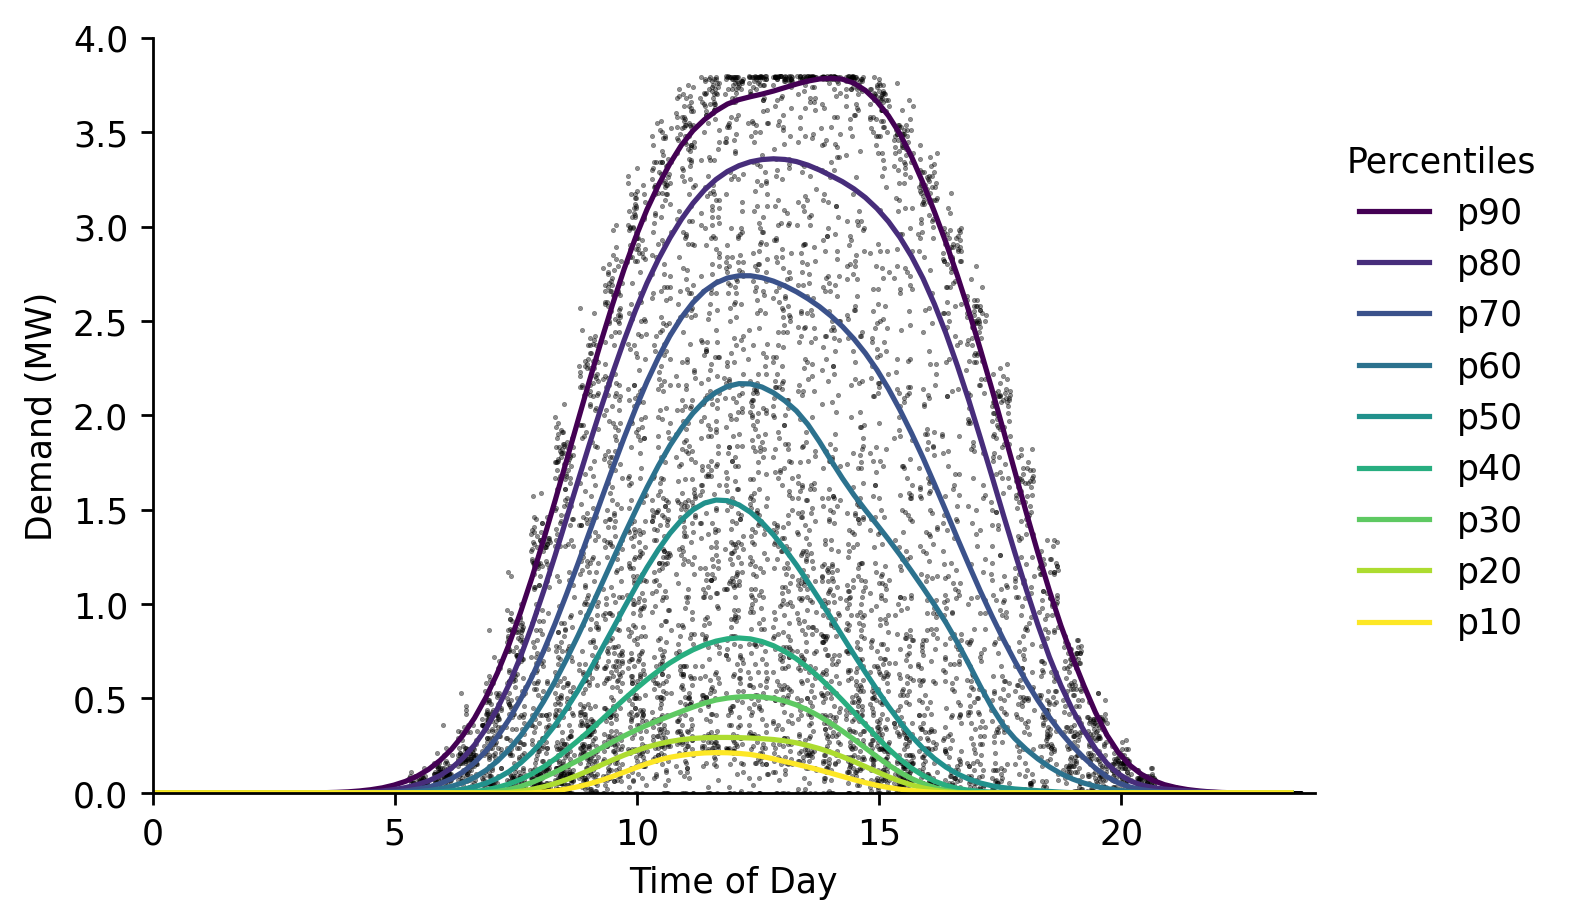

In [137]:
x_jittered = x + (np.random.uniform(size=len(x)) - 0.5)/2.5

# Plotting
fig, ax = plt.subplots(dpi=250)

ax.scatter(x_jittered, y, s=0.2, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.9), title='Percentiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Demand (MW)')
ax.set_xlim(0, 24)
ax.set_ylim(0, 4)

fig.savefig('../img/daily_solar_profile.png')

## Proportion of days during which we can fully charge the battery

It may be useful to know the proportion of days during which the battery can be fully charged. 

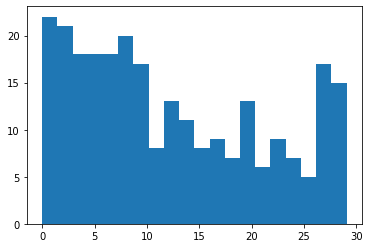

Proportion of days where solar generation exceeds 6 MWh: 69.08%


In [138]:
df_solar_hrs = df.between_time('00:00:00', '15:00:00')
pv_generation = df_solar_hrs.groupby(df_solar_hrs.index.date).sum()['pv_power_mw']*0.5 # available daily energy from PV

fig, ax = plt.subplots()
ax.hist(pv_generation, bins=20)
plt.show()

prop = np.sum(pv_generation >= 6)/pv_generation.size
print("Proportion of days where solar generation exceeds 6 MWh: {:.2f}%".format(prop*100))

## Optimal charging with perfect foresight

We will now develop an algorithm to determine the optimal charging schedule given a perfect solar forecast. 

The scoring function for the generation component rewards us taking as much energy as possible from solar PV. The proportion of energy from PV for a day $d$ is given by $$p_{d,1} = \frac{\sum{P_{d,k}}}{\sum{B_{d,k}}}$$ where we are summing over all periods $k$. An equivalent equation is applies for $p_{d,2}$ which is the energy that is drawn from the grid. The scoring function rewards $p_{d,1}$ over $p_{d,2}$ in a ratio of 3 to 1. 

Any schedule which fully exploits the solar PV potential until the battery is charged is equally good in terms of the scoring function. However, it may be worth considering methods which give a smoother charge profile for the purposes of producing a robust model for unseen days.

In addition, we need to have a method of intelligently allocating charge when the solar PV potential is less than the capacity of the battery.

Some possible methods for this:

- Naively reallocate over the middle of they day (say 09:00--15:00)
- Add charge to periods where charge has already been committed.
- Use a forecast for PV output and allocate charge proportionally to the forecast.

In [139]:
#exports
def extract_solar_profile(s_solar_sample_dt, start_time='00:00', end_time='15:00'):
    dt = str(s_solar_sample_dt.index[0].date())
    solar_profile = s_solar_sample_dt[f'{dt} {start_time}':f'{dt} {end_time}'].values

    return solar_profile

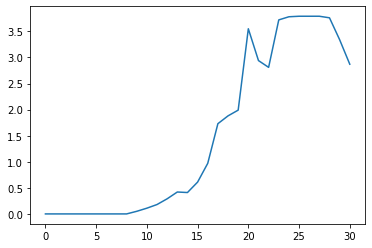

In [140]:
s_pv = df['pv_power_mw']
solar_profile = sample_random_day(s_pv).pipe(extract_solar_profile)

plt.plot(solar_profile)

For perfect foresight, any schedule that draws all of the available solar power or 6 MWh (if the total solar production exceeds 6 MWh) is equally good. 

This first approach will aim to draw greedily from  until 6 MWh is satisfied, or all of the solar production has been expended.

In cases where there is not enough solar PV to fill the battery, we will then uniformly add the remaining capacity across all periods.

**Note: this seems to work on this dataset but won't if there is a very large spike in solar PV, such topping up uniformly causes a constraint to be violated. It also may not work if the number of periods over which we top up is decreased.**

In [548]:
#exports

def charge_profile_greedy(solar_profile, capacity=6, initial_charge=0, max_charge_rate=2.5, time_unit=0.5):
    order = np.flip(np.argsort(random_day))
    charge = initial_charge
    solution = np.zeros(len(solar_profile))
    for i in order:
        solar_available = np.minimum(solar_profile[i], max_charge_rate)
        solar_available = min(solar_available, (capacity - charge)/time_unit) 
        solution[i] = solar_available
        charge = np.sum(solution)*time_unit
        if charge > capacity:
            break
    return solution

def topup_charge_naive(charge_profile, capacity=6, time_unit=0.5, period_start=16, period_end=30):
    charge = np.sum(charge_profile)*time_unit
    spare_cap = capacity - charge
    topup_value = spare_cap/((period_end-period_start)*time_unit)
    new_profile = np.copy(charge_profile)
    new_profile[period_start:period_end] += topup_value # Add topup_value uniformly between start and end periods
    return new_profile

def scale_charge(charge_profile, capacity=6, time_unit=0.5):
    """
    Scale a charging profile to sum to capacity/time_unit while maintaining its shape
    """
    charge_profile = (capacity/time_unit)*charge_profile/np.sum(charge_profile)
    return charge_profile

def optimal_charge_profile(solar_profile, capacity=6, time_unit=0.5, max_charge_rate=2.5):
    solution = charge_profile_greedy(solar_profile)
    solution = topup_charge_naive(solution)
    assert np.isclose(np.sum(solution), capacity/time_unit), "Does not meet capacity constraint".format(np.sum(solution)) 
    assert np.all(solution <= max_charge_rate), "Does not meet max charge rate constraint. Max is {}".format(np.max(solution))
    return solution

random_day = sample_random_day(s_pv).pipe(extract_solar_profile)
x = optimal_charge_profile(random_day) # Note there is sometimes a rounding error here

The danger with this method is that it can be quite spiky. I wonder if this (a) makes the function difficult to learn (b) is too risky as compared with hedging bets with a more smoother approach. 

In [549]:
# TODO: consider a different optimal charging algorithm that gives a smoother charge profile
# ^^^^  perhaps similar to the load flattening idea

Below we will construct the charge profiles for the dataset, which we will then use as target values. 

In [546]:
#exports
def construct_charge_s(s_pv, start_time='00:00', end_time='15:00'):
    s_charge = pd.Series(index=s_pv.index, dtype=float).fillna(0)

    for dt in s_pv.index.strftime('%Y-%m-%d').unique():
        solar_profile = s_pv[dt].pipe(extract_solar_profile)
        charge_profile = optimal_charge_profile(solar_profile)
        s_charge[f'{dt} {start_time}':f'{dt} {end_time}'] = charge_profile

    return s_charge

s_charge = construct_charge_s(s_pv)

<AxesSubplot:xlabel='datetime'>

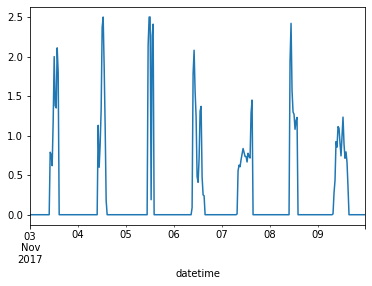

In [547]:
s_charge.iloc[:48*7].plot()

With the greedy algorithm we can analyse the periods during which charging occurs:

<AxesSubplot:xlabel='time'>

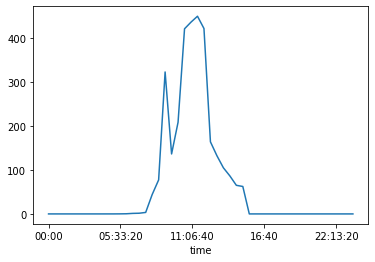

In [471]:
s_charge.groupby(s_charge.index.time).sum().plot()

Unsurprisingly we never charge before 5am. We can therefore truncate our training to just look at 05:00--15:30. 

This algorithm does not guarantee that we will fill the battery: on days when less than 6 MWh of solar PV are available, we still need to charge the battery to full. With perfect foresight it would not matter how we schedule the non-PV charging. However, for this task we really want to pick periods with the highest probability of solar PV generation (e.g. not the middle of the night). 

In [472]:
# TODO: optimise with respect to a PV forecast.
# ^^^^  this would give a better method for scheduling when the expected solar PV is low.

### Model development: charging

Following the same structure as battery discharge, we will aim to predict the optimal charge schedule. 

In [473]:
#exports 
def construct_df_charge_features(df):
    # Filtering for the temperature weather data
    df_features = df[df.columns[df.columns.str.contains('temp_location')]].copy()
    
    # Adding lagged demand
    df_features['demand_7d_lag'] = df['demand_MW'].shift(48*7)

    # Adding datetime features
    dts = df_features.index.tz_convert('Europe/London') # We want to use the 'behavioural' timezone

    df_features['weekend'] = dts.dayofweek.isin([5, 6]).astype(int)
    df_features['hour'] = dts.hour + dts.minute/60
    df_features['doy'] = dts.dayofyear
    df_features['dow'] = dts.dayofweek
    
    # Removing NaN values
    df_features = df_features.dropna()
    
    return df_features

#exports
def extract_charging_datetimes(df, start_hour=5, end_hour=15):
    hour = df.index.hour + df.index.minute/60
    charging_datetimes = df.index[(hour>=start_hour) & (hour<=end_hour)]
    
    return charging_datetimes



In [474]:
df_features = construct_df_charge_features(df)
charging_datetimes = extract_charging_datetimes(df_features)

X = df_features.loc[charging_datetimes].values
y = s_charge.loc[charging_datetimes].values

In [475]:
df_pred = clean.generate_kfold_preds(X, y, LinearRegression(), index=charging_datetimes)

df_pred.head()

,pred,true
datetime,,
2017-11-10 05:00:00+00:00,0.103503,0.0
2017-11-10 05:30:00+00:00,0.160436,0.0
2017-11-10 06:00:00+00:00,0.256295,0.0
2017-11-10 06:30:00+00:00,0.352491,0.0
2017-11-10 07:00:00+00:00,0.469711,0.0


We need to fix the predictions such that they satisfy the battery constraints. We will do this in the same way as applied in the battery discharge component, first clipping the charge rate to be between 0--2.5MW, then normalising such that the total charge sums to 6 MWh.

In [476]:
#exports
def normalise_total_charge(s_pred, charge=6., time_unit=0.5):
    s_daily_charge = s_pred.groupby(s_pred.index.date).sum()

    for date, total_charge in s_daily_charge.items():
        s_pred.loc[str(date)] *= (charge/(time_unit*total_charge))
        
    return s_pred    

clip_charge_rate = lambda s_pred, max_rate=2.5, min_rate=0: s_pred.clip(lower=max_rate, upper=min_rate)

post_pred_charge_proc_func = lambda s_pred: (s_pred
                                      .pipe(clip_charge_rate)
                                      .pipe(normalise_total_charge)
                                     )
    

In [477]:
post_pred_charge_proc_func(s_pred).groupby(s_pred.index.date).sum().value_counts()

12.0    184
12.0     27
12.0     24
12.0      9
12.0      8
12.0      2
12.0      1
Name: pred, dtype: int64

<br>

Finally we'll export the relevant code to our `batopt` module

In [17]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-data-cleaning.ipynb.
Converted 02-battery-discharge.ipynb.
Converted 03-pv-forecast.ipynb.
Converted 04-battery-optimisation.ipynb.
Converted 05-evaluation.ipynb.
Converted 06-pipeline.ipynb.
